# Notebook template for pseudotime (Slingshot)

In [1]:
library(Seurat)
library(Signac)
library(slingshot)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.

Attaching SeuratObject

Loading required package: princurve

Loading required package: TrajectoryUtils

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrde

In [2]:
# From Kallisto|bustools manual (https://bustools.github.io/BUS_notebooks_R/slingshot.html)
library(BUSpaRse)
library(tidyverse)
library(tidymodels)
library(Seurat)
library(scales)
library(viridis)
library(Matrix)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ dplyr::collapse()     masks IRanges::collapse()
✖ dplyr::combine()      masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()        masks matrixStats::count()
✖ dplyr::desc()         masks IRanges::desc()
✖ tidyr::expand()       masks S4Vectors::expand()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::first()        masks S4Vectors::first()
✖ dplyr::lag()          masks stats::lag()
✖ ggplot2::Position()   masks BiocGenerics::Position(), base::Position()
✖ purrr::reduce()       masks GenomicRanges::reduce(), IRanges::reduce(), Signac::reduce()
✖ dplyr::rename()       masks S4

## Load the dataset (h5Seurat object)

In [3]:
# import Seurat object
multiome <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_RNA_ATAC.rds")
multiome

An object of class Seurat 
701031 features across 95196 samples within 4 assays 
Active assay: peaks_integrated (640834 features, 0 variable features)
 3 other assays present: RNA, SCT, integrated
 6 dimensional reductions calculated: integrated_lsi, umap, integrated_pca, umap.rna, umap.atac, wnn.umap

In [19]:
DefaultAssay(multiome) <- "RNA"

multiome <- NormalizeData(multiome, 
                          normalization.method = "LogNormalize",
                          scale.factor = 10000, assay="RNA")
multiome

In [21]:
# multiome@assays$RNA@data

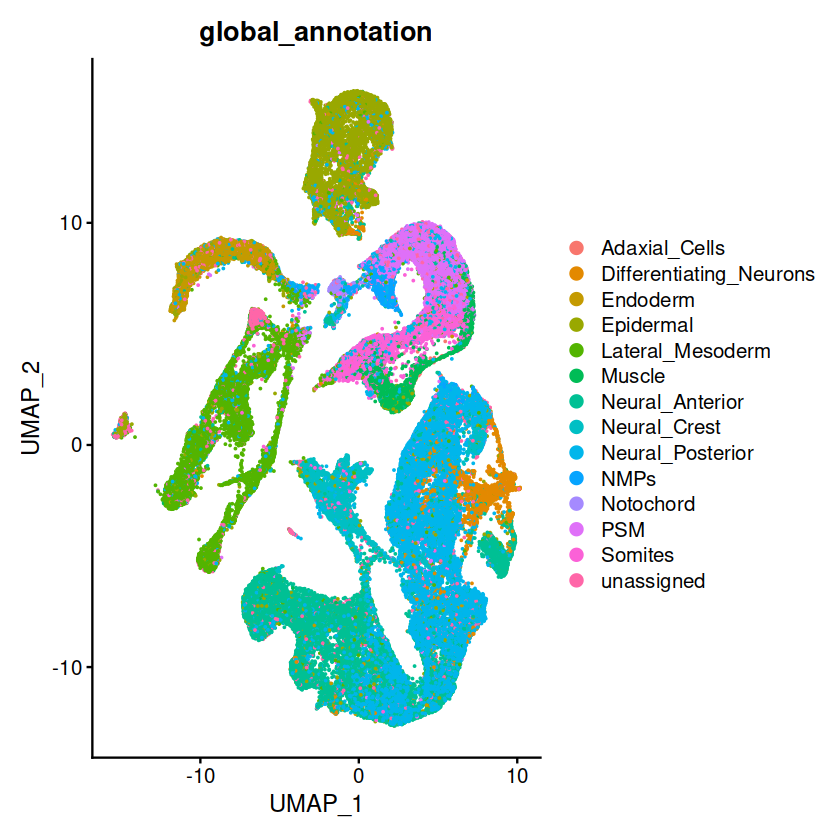

In [9]:
DimPlot(multiome, group.by = 'global_annotation')

# Slingshot

### Trajectory inference 
- https://bustools.github.io/BUS_notebooks_R/slingshot.html

While the slingshot vignette uses SingleCellExperiment, slingshot can also take a matrix of cell embeddings in reduced dimension as input. We can optionally specify the cluster to start or end the trajectory based on biological knowledge. Here, since quiescent neural stem cells are in cluster 4, the starting cluster would be 4 near the top left of the previous plot.

Here, UMAP projections are used for trajectory inference, as in Monocle 3, for the purpose of visualization. However, I no longer consider this a good idea, due to distortions introduced by UMAP. See this paper for the extent non-linear dimension reduction methods distort the data. The latent dimension of the data is most likely far more than 2 or 3 dimensions, so forcing it down to 2 or 3 dimensions are bound to introduce distortions, just like how projecting the spherical surface of the Earth to 2 dimensions in maps introduces distortions. Furthermore, after the projection, some trajectories are no longer topologically feasible. For instance, imagine a stream coming out of the hole of a doughnut in 3D. This is not possible in 2D, so when that structure is projected to 2D, part of the stream may become buried in the middle of the doughnut, or the doughnut may be broken to allow the stream through, or part of the steam will be intermixed with part of the doughnut though they shouldn’t. I recommend using a larger number of principal components instead, but in that case, the lineages and principal curves can’t be visualized (we can plot the curves within a 2 dimensional subspace, such as the first 2 PCs, but that usually looks like abstract art and isn’t informative about the lineages).

## compute the pseudotime (Slingshot)

In [22]:
# https://bustools.github.io/BUS_notebooks_R/slingshot.html
sds <- slingshot(Embeddings(multiome, "umap.atac"), 
                 clusterLabels = multiome$global_annotation, 
                 start.clus = "NMPs" , stretch = 0)

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE."
Warning message:
"u

In [41]:
sds

class: PseudotimeOrdering 
dim: 95196 5 
metadata(4): lineages mst slingParams curves
pathStats(2): pseudotime weights
cellnames(95196): AAACAGCCACCTAAGC-1_1 AAACAGCCAGGGAGGA-1_1 ...
  TTTGTTGGTGCGCGTA-1_7 TTTGTTGGTTAAGGCC-1_7
cellData names(2): reducedDim clusterLabels
pathnames(5): Lineage1 Lineage2 Lineage3 Lineage4 Lineage5
pathData names(0):

In [32]:
sds@elementMetadata$reducedDim %>% head()

,UMAP_1,UMAP_2
AAACAGCCACCTAAGC-1_1,-0.05534897,13.906811
AAACAGCCAGGGAGGA-1_1,-5.98380317,3.982057
AAACAGCCATAGACCC-1_1,6.16231309,-6.494239
AAACATGCAAACTCAT-1_1,4.84756433,1.973772
AAACATGCAAGGACCA-1_1,-2.62346305,-8.366639
AAACATGCAAGGATTA-1_1,3.64125381,-6.259151


In [40]:
multiome@reductions

$integrated_lsi
A dimensional reduction object with key integratedlsi_ 
 Number of dimensions: 50 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: peaks_integrated 

$umap
A dimensional reduction object with key UMAP_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: peaks_integrated 

$integrated_pca
A dimensional reduction object with key PC_ 
 Number of dimensions: 100 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: integrated 

$umap.rna
A dimensional reduction object with key UMAP_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: integrated 

$umap.atac
A dimensional reduction object with key UMAP_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: peaks_i

In [13]:
saveRDS(sds, file="/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_RNA_ATAC_slingshot.rds")

## ---- Restart point ----

In [4]:
sds <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_RNA_ATAC_slingshot.rds")
sds

class: PseudotimeOrdering 
dim: 95196 5 
metadata(4): lineages mst slingParams curves
pathStats(2): pseudotime weights
cellnames(95196): AAACAGCCACCTAAGC-1_1 AAACAGCCAGGGAGGA-1_1 ...
  TTTGTTGGTGCGCGTA-1_7 TTTGTTGGTTAAGGCC-1_7
cellData names(2): reducedDim clusterLabels
pathnames(5): Lineage1 Lineage2 Lineage3 Lineage4 Lineage5
pathData names(0):

In [6]:
#' Assign a color to each cell based on some value
#' 
#' @param cell_vars Vector indicating the value of a variable associated with cells.
#' @param pal_fun Palette function that returns a vector of hex colors, whose
#' argument is the length of such a vector.
#' @param ... Extra arguments for pal_fun.
#' @return A vector of hex colors with one entry for each cell.
cell_pal <- function(cell_vars, pal_fun,...) {
  if (is.numeric(cell_vars)) {
    pal <- pal_fun(100, ...)
    return(pal[cut(cell_vars, breaks = 100)])
  } else {
    categories <- sort(unique(cell_vars))
    pal <- setNames(pal_fun(length(categories), ...), categories)
    return(pal[cell_vars])
  }
}

In [7]:
cell_colors <- cell_pal(multiome$global_annotation, brewer_pal("qual", "Set2"))
# cell_colors_clust <- cell_pal(multiome$seurat_clusters, hue_pal())

Warning message in RColorBrewer::brewer.pal(n, pal):
"n too large, allowed maximum for palette Set2 is 8
Returning the palette you asked for with that many colors
"


In [19]:
# library(RColorBrewer)
# library(BUSpaRse)
# library(tidyverse)
# library(tidymodels)
# #library(Seurat)
# library(scales)
# library(viridis)
# library(Matrix)

# cell_colors <- cell_pal(TDR118$predicted.id, brewer_pal("qual", "Set2"))
# # cell_colors_clust <- cell_pal(seu$seurat_clusters, hue_pal())

Warning message in RColorBrewer::brewer.pal(n, pal):
"n too large, allowed maximum for palette Set2 is 8
Returning the palette you asked for with that many colors
"


In [9]:
sds@metadata$lineages

$Lineage1
[1] "NMPs"                    "Epidermal"              
[3] "Notochord"               "unassigned"             
[5] "Neural_Crest"            "Neural_Anterior"        
[7] "Neural_Posterior"        "Differentiating_Neurons"

$Lineage2
[1] "NMPs"          "Epidermal"     "Notochord"     "unassigned"   
[5] "Adaxial_Cells" "Somites"       "Muscle"       

$Lineage3
[1] "NMPs"             "Epidermal"        "Notochord"        "unassigned"      
[5] "Lateral_Mesoderm"

$Lineage4
[1] "NMPs"       "Epidermal"  "Notochord"  "unassigned" "Endoderm"  

$Lineage5
[1] "NMPs" "PSM"

In [42]:
library(ggplot2)
library(scales) # for the alpha function

In [46]:
# extract the UMAP coordinates
umap_df <- sds@elementMetadata$reducedDim

# converting to a dataframe fot ggplot
umap_df$cluster <- factor(sds@elementMetadata$clusterLabels)

# Add pseudotime information
# umap_df$pseudotime <- sds@pathStats$pseudotime[,1] # Assuming you're interested in the first lineage

Warning message in umap_df$cluster <- factor(sds@elementMetadata$clusterLabels):
"Coercing LHS to a list"


In [56]:
umap_df <- as.data.frame(sds@elementMetadata$reducedDim)
umap_df %>% head

,UMAP_1,UMAP_2
,<dbl>,<dbl>
AAACAGCCACCTAAGC-1_1,-0.05534897,13.906811
AAACAGCCAGGGAGGA-1_1,-5.98380317,3.982057
AAACAGCCATAGACCC-1_1,6.16231309,-6.494239
AAACATGCAAACTCAT-1_1,4.84756433,1.973772
AAACATGCAAGGACCA-1_1,-2.62346305,-8.366639
AAACATGCAAGGATTA-1_1,3.64125381,-6.259151


In [59]:
multiome$global_annotation %>% head()

AAACAGCCACCTAAGC-1_1 AAACAGCCAGGGAGGA-1_1 AAACAGCCATAGACCC-1_1 
         "Epidermal"   "Lateral_Mesoderm"                "PSM" 
AAACATGCAAACTCAT-1_1 AAACATGCAAGGACCA-1_1 AAACATGCAAGGATTA-1_1 
  "Neural_Posterior"    "Neural_Anterior"    "Neural_Anterior"

In [61]:
annotation.df <- as.data.frame(multiome$global_annotation)

cluster_labels_df <- data.frame(Cell_ID = rownames(annotation.df), Cluster = annotation.df, row.names = NULL)
cluster_labels_df

ERROR: Error in data.frame(Cell_ID = rownames(multiome$global_annotation), Cluster = multiome$global_annotation, : arguments imply differing number of rows: 0, 95196


ERROR: Error in annotation.df$multiome$global_annotation: $ operator is invalid for atomic vectors


In [60]:
as.data.frame(multiome$global_annotation) %>% head()

,multiome$global_annotation
,<chr>
AAACAGCCACCTAAGC-1_1,Epidermal
AAACAGCCAGGGAGGA-1_1,Lateral_Mesoderm
AAACAGCCATAGACCC-1_1,PSM
AAACATGCAAACTCAT-1_1,Neural_Posterior
AAACATGCAAGGACCA-1_1,Neural_Anterior
AAACATGCAAGGATTA-1_1,Neural_Anterior


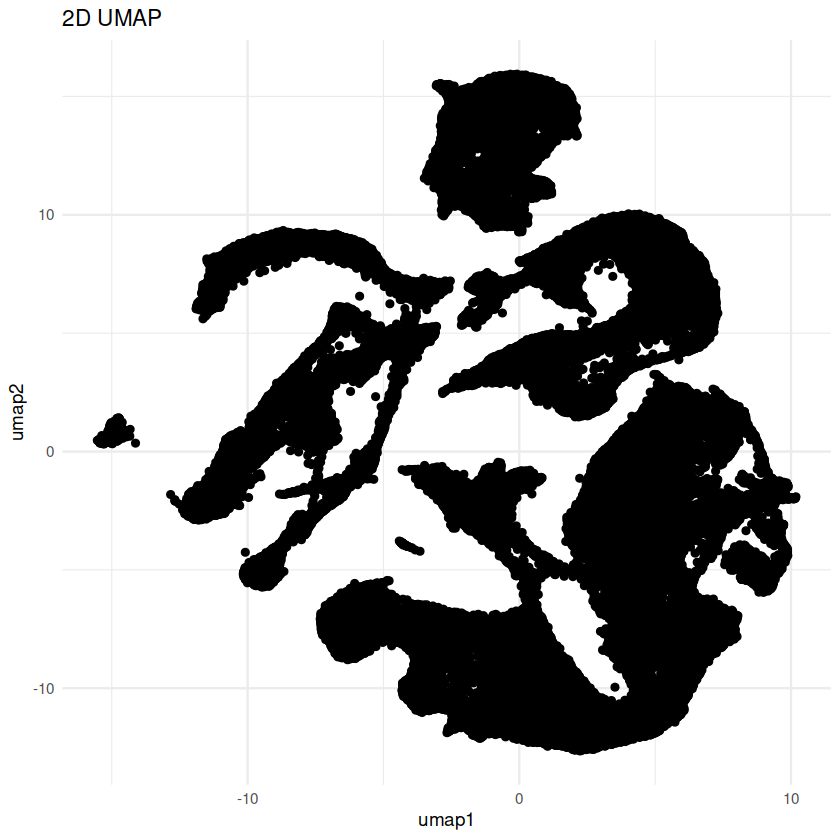

In [58]:
# check the computed lineages
ggplot(umap_df, aes(x = UMAP_1, y = UMAP_2)) + 
    geom_point() + 
    theme_minimal()+
    labs(title="2D UMAP", x="umap1", y="umap2")
# lines(SlingshotDataSet(sds), lwd=2, type="lineages", col="black")

In [13]:
sds@metadata$curves

In [ ]:
summary(sds$)

In [57]:
sce <- as.SingleCellExperiment(multiome)

Warning message in .check_reddim_names(x, value, withDimnames):
"non-NULL 'rownames(value)' should be the same as 'colnames(x)' for
'reducedDim<-'. This will be an error in the next release of
Bioconductor."


In [ ]:
sce

In [ ]:
# https://bustools.github.io/BUS_notebooks_R/slingshot.html
sds <- slingshot(sce$, 
                 clusterLabels = TDR118$predicted.id, 
                 start.clus = "NMPs" , stretch = 0)

In [58]:
sce

class: SingleCellExperiment 
dim: 248320 13022 
metadata(0):
assays(2): counts logcounts
rownames(248320): 1-2372-3057 1-6507-7253 ... 9-56452315-56452858
  9-56459068-56459827
rowData names(0):
colnames(13022): AAACAGCCACCTAAGC-1 AAACAGCCAGGGAGGA-1 ...
  TTTGTTGGTTCGGGAT-1 TTTGTTGGTTTGTGGA-1
colData names(61): orig.ident nCount_RNA ... nFeature_peaks_bulk ident
reducedDimNames(2): LSI.CELLRANGER ATAC.UMAP.CELLRANGER
mainExpName: ATAC
altExpNames(4): RNA peaks_bulk peaks_celltype SCT

In [14]:
plot(reducedDim(sds), col = cell_colors, pch = 16, cex = 0.5)
lines(sds, lwd = 2, type = 'lineages', col = 'black')

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'plot': unable to find an inherited method for function 'reducedDim' for signature '"PseudotimeOrdering", "missing"'


In [35]:
sds$reducedDimNames <- ""

class: PseudotimeOrdering 
dim: 13022 8 
metadata(4): lineages mst slingParams curves
pathStats(2): pseudotime weights
cellnames(13022): AAACAGCCACCTAAGC-1 AAACAGCCAGGGAGGA-1 ...
  TTTGTTGGTTCGGGAT-1 TTTGTTGGTTTGTGGA-1
cellData names(2): reducedDim clusterLabels
pathnames(8): Lineage1 Lineage2 ... Lineage7 Lineage8
pathData names(0):

In [31]:
example(SingleCellExperiment, echo=FALSE)

In [33]:
sce

class: SingleCellExperiment 
dim: 200 100 
metadata(0):
assays(2): counts logcounts
rownames: NULL
rowData names(0):
colnames: NULL
colData names(0):
reducedDimNames(2): PCA tSNE
mainExpName: NULL
altExpNames(0):

In [40]:
reducedDim(sce)

0.64376623,0.813143676,0.28392991,0.57279717,0.427765494
0.24726170,0.938975123,0.01542378,0.88532046,0.176724345
0.58083696,0.880066830,0.05561764,0.84227344,0.081501588
0.95713128,0.897374195,0.41983394,0.93050262,0.681338809
0.58978872,0.828042952,0.11250493,0.71878702,0.558503560
0.29648649,0.014037263,0.90775377,0.40147276,0.438827317
0.31207849,0.601148724,0.70503850,0.03706051,0.009623426
0.32806259,0.899485754,0.70346683,0.15336207,0.821195507
0.39245075,0.810614891,0.43241406,0.03657749,0.436220531
0.49190893,0.300221348,0.80781754,0.33885125,0.570298559
0.52254623,0.622386594,0.52772952,0.41483105,0.175198260


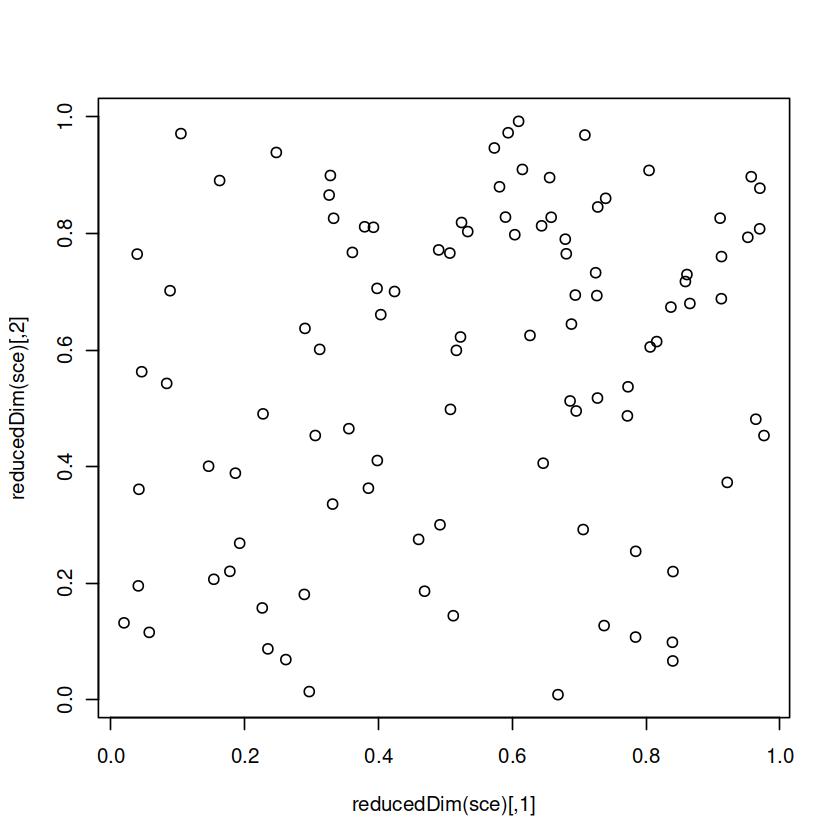

In [39]:
plot(reducedDim(sce))

In [38]:
lines(sds, lwd=2, type = "lineages". col="black")

ERROR: Error in parse(text = x, srcfile = src): <text>:1:36: unexpected symbol
1: lines(sds, lwd=2, type = "lineages".
                                       ^


In [18]:
sds

class: PseudotimeOrdering 
dim: 13022 8 
metadata(4): lineages mst slingParams curves
pathStats(2): pseudotime weights
cellnames(13022): AAACAGCCACCTAAGC-1 AAACAGCCAGGGAGGA-1 ...
  TTTGTTGGTTCGGGAT-1 TTTGTTGGTTTGTGGA-1
cellData names(2): reducedDim clusterLabels
pathnames(8): Lineage1 Lineage2 ... Lineage7 Lineage8
pathData names(0):

In [22]:
slingLineages(sds)

$Lineage1
[1] "NMPs"         "Neural_Crest" "Somites"      "Muscle"       "unassigned"  
[6] "Epidermal"   

$Lineage2
[1] "NMPs"             "Neural_Crest"     "Somites"          "Muscle"          
[5] "unassigned"       "Lateral_Mesoderm"

$Lineage3
[1] "NMPs"            "Neural_Crest"    "Somites"         "Muscle"         
[5] "unassigned"      "Neural_Anterior"

$Lineage4
[1] "NMPs"         "Neural_Crest" "Somites"      "Muscle"       "unassigned"  
[6] "Endoderm"    

$Lineage5
[1] "NMPs"                    "Neural_Crest"           
[3] "Neural_Posterior"        "Differentiating_Neurons"

$Lineage6
[1] "NMPs"         "Neural_Crest" "PSM"         

$Lineage7
[1] "NMPs"          "Neural_Crest"  "Adaxial_Cells"

$Lineage8
[1] "NMPs"      "Notochord"

In [28]:
slingLineages(sds)$Lineage1

[1] "NMPs"         "Neural_Crest" "Somites"      "Muscle"       "unassigned"  
[6] "Epidermal"

In [23]:
pto.sds <- slingPseudotime(sds) # NO ERROR HERE
pto.sds

,Lineage1,Lineage2,Lineage3,Lineage4,Lineage5,Lineage6,Lineage7,Lineage8
AAACAGCCACCTAAGC-1,21.629398,NA,23.478043,NA,27.359517,NA,NA,NA
AAACAGCCAGGGAGGA-1,NA,15.579245,NA,NA,NA,NA,NA,NA
AAACAGCCATAGACCC-1,NA,NA,NA,19.270670,NA,NA,NA,NA
AAACATGCAAACTCAT-1,NA,NA,NA,NA,11.327246,NA,NA,NA
AAACATGCAAGGACCA-1,13.215525,NA,12.790338,12.384155,NA,NA,NA,NA
AAACATGCAAGGATTA-1,NA,NA,NA,NA,5.746124,NA,NA,8.447296
AAACATGCACGTTACA-1,NA,NA,NA,NA,NA,25.899317,NA,NA
AAACATGCAGGACCTT-1,NA,NA,NA,NA,NA,12.847718,9.247499,NA
AAACATGCAGGCGATA-1,NA,NA,15.833179,NA,NA,NA,NA,NA
AAACATGCAGTTTCTC-1,10.672908,NA,10.269812,10.308050,NA,NA,NA,NA


In [25]:
cw.sds <- slingCurveWeights(SlingshotDataSet(sds))  # NO ERROR HERE
cw.sds

,Lineage1,Lineage2,Lineage3,Lineage4,Lineage5,Lineage6,Lineage7,Lineage8
AAACAGCCACCTAAGC-1,1.0000000,0.0000000,0.6101254,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000
AAACAGCCAGGGAGGA-1,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
AAACAGCCATAGACCC-1,0.0000000,0.0000000,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000
AAACATGCAAACTCAT-1,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000
AAACATGCAAGGACCA-1,1.0000000,0.0000000,0.5812696,0.4103154,0.0000000,0.0000000,0.0000000,0.0000000
AAACATGCAAGGATTA-1,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000,0.0000000,0.0000000,0.6834914
AAACATGCACGTTACA-1,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000,0.0000000,0.0000000
AAACATGCAGGACCTT-1,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000,0.2702878,0.0000000
AAACATGCAGGCGATA-1,0.0000000,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
AAACATGCAGTTTCTC-1,1.0000000,0.0000000,1.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [30]:
slingshotPlot(sds, plot.type = "pseudotime_umap")

ERROR: Error in slingshotPlot(sds, plot.type = "pseudotime_umap"): could not find function "slingshotPlot"


In [32]:
sds

class: PseudotimeOrdering 
dim: 13022 8 
metadata(4): lineages mst slingParams curves
pathStats(2): pseudotime weights
cellnames(13022): AAACAGCCACCTAAGC-1 AAACAGCCAGGGAGGA-1 ...
  TTTGTTGGTTCGGGAT-1 TTTGTTGGTTTGTGGA-1
cellData names(2): reducedDim clusterLabels
pathnames(8): Lineage1 Lineage2 ... Lineage7 Lineage8
pathData names(0):

In [26]:
plot(reducedDim(sds), col = cell_colors, pch = 16, cex = 0.5)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'plot': unable to find an inherited method for function 'reducedDim' for signature '"PseudotimeOrdering", "missing"'


In [15]:
plot(reducedDim(sds), col = cell_colors, pch = 16, cex = 0.5)
lines(sds, lwd = 2, type = 'lineages', col = 'black')

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'plot': unable to find an inherited method for function 'reducedDim' for signature '"PseudotimeOrdering", "missing"'


## visualization of accessibility over pseudotime